In [0]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import itertools  
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Learning Long Time Dependencies 
## Generate Data 

In [0]:
#question 4 generate data.
def one_hot(num):
  return [1 if i==num else 0 for i in range(101)] #p = 100 so p+1 dimension vector 
# two kinds of seqs. (x,a,x) and (y,a,y)
# (x,a,x) sequence 


def seq_xax():
  #generate x
  p = 100
  seq = [] 
  for i in range(100): # x 
    seq.append(one_hot(i))
  curr = random.randint(1, p-1)
  seq.append(one_hot(curr))
  prev = curr
  for i in range(p-2): # ai1,....., aip-1
    curr = random.randint(prev, p-1)
    seq.append(one_hot(curr))
    prev = curr
  for i in range(100): # x 
    seq.append(one_hot(i))
  return seq
def seq_yay():
  p = 100
  seq = []
  seq.append(one_hot(p+1)) # y
  curr = random.randint(1, p-1)
  seq.append(one_hot(curr))
  prev = curr
  for i in range(p-2): # ai1,....., aip-1
    curr = random.randint(prev, p-1)
    seq.append(one_hot(curr))
    prev = curr
  seq.append(one_hot(p+1)) # y
  return seq

def gen_data(num_data):
  train_data = []
  for i in range(num_data):
    if random.random() > 0.5:
      curr_seq = seq_xax()
      for symbol in curr_seq:
        train_data.append(symbol)
    else:
      curr_seq = seq_yay()
      for symbol in curr_seq:
        train_data.append(symbol)
  return train_data

In [3]:
train_data = gen_data(10)
test_data = gen_data(10)
train_data = np.array(train_data)
print((np.shape(train_data)))

(2198, 101)


## Transform Data 
- We do this so as to have 100 RNNCells in each layer.  
- Also, so that a sequence as destined target to achieve i.e the next symbol 

In [4]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + seq_len: i + seq_len + 1]
        # print(np.shape(y_i))
        x.append(np.array(x_i))
        y.append(np.array(y_i).astype('float64'))
    x_arr = np.array(x)
    y_arr = np.array(y)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

seq_len = 100 
train_input, train_target = transform_data(train_data, seq_len)
test_input, test_target = transform_data(test_data, seq_len)
print(np.shape(train_input))
print(np.shape((train_target)))
# print(train_target[:5])
# # print(train_input[:5])

torch.Size([2098, 100, 101])
torch.Size([2098, 1, 101])


## LSTM
### LSTM Architecture  
- The architecture has 3 LSTM layers stacked on top of each other.
- Then we have a linear fully connected (FC) layer.  
- We have a softmax layer as an activation function before the output layer.
- We, further, make sure that the input size and the output size is 101 (our one-hot vector size)  

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=101, hidden_layer_size=150, output_size=101, num_layers = 3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(3,1,self.hidden_layer_size),
                            torch.zeros(3,1,self.hidden_layer_size))
        self.soft = nn.Softmax(dim=1)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.soft(self.linear(lstm_out.view(len(input_seq), -1)))
        return predictions[-1]

- We define which optimiser to use. Here, it is Adam 
- Learning rate is also defined. Here, it is $2*10^{-8}$ 
- We also define which loss function to use. Here, we used MSE loss. 

In [0]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2*10e-8)

### Training the Model 
- We run it for 35 epochs. In each epoch, we go through all the sequences one by one. 
- Then, we compute gradients and perform a backpropagation. 

In [7]:
epochs = 35
loss_epoch = []
index = []
for i in range(epochs): 
    index.append(i)
    for seq, labels in zip(train_input, train_target):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(3, 1, model.hidden_layer_size),
                             torch.zeros(3, 1, model.hidden_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    loss_epoch.append(single_loss.item()) # Each epoch has 10 sequences. So printing after epoch for better representation. Talk abotu multi-dirac 
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 101])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00980381
epoch:   1 loss: 0.00980182
epoch:   2 loss: 0.00979977
epoch:   3 loss: 0.00979764
epoch:   4 loss: 0.00979541
epoch:   5 loss: 0.00979308
epoch:   6 loss: 0.00979062
epoch:   7 loss: 0.00978801
epoch:   8 loss: 0.00978522
epoch:   9 loss: 0.00978221
epoch:  10 loss: 0.00977895
epoch:  11 loss: 0.00977536
epoch:  12 loss: 0.00977140
epoch:  13 loss: 0.00976697
epoch:  14 loss: 0.00976194
epoch:  15 loss: 0.00975619
epoch:  16 loss: 0.00974949
epoch:  17 loss: 0.00974158
epoch:  18 loss: 0.00973206
epoch:  19 loss: 0.00972034
epoch:  20 loss: 0.00970558
epoch:  21 loss: 0.00968642
epoch:  22 loss: 0.00966067
epoch:  23 loss: 0.00962465
epoch:  24 loss: 0.00957188
epoch:  25 loss: 0.00949079
epoch:  26 loss: 0.00936081
epoch:  27 loss: 0.00914906
epoch:  28 loss: 0.00881456
epoch:  29 loss: 0.00832882
epoch:  30 loss: 0.00770760
epoch:  31 loss: 0.00702174
epoch:  32 loss: 0.00636293
epoch:  33 loss: 0.00579880
epoch:  34 loss: 0.00535443


### Our Model loss curve
The below plot shows epoch vs loss curve 

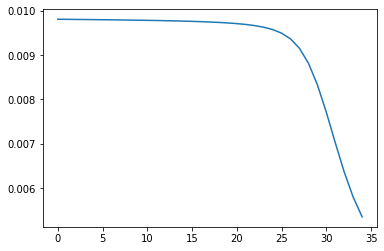

In [8]:
plt.plot(index, loss_epoch)

### Test our Model


In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  with torch.no_grad():
        model.hidden_cell = (torch.zeros(3, 1, model.hidden_layer_size),
                              torch.zeros(3, 1, model.hidden_layer_size))
        seq = seq.float()
        seq= Variable(seq)
        y_pred = model(seq)
        test_outputs.append(y_pred)

In [10]:
# print(test_outputs[:1])
_, target = test_outputs[0].max(dim=0)
print(target)
# print(test_target[:1])
print(test_target[0])
test = (test_target[0].reshape(-1,))
_, target = test.max(dim=0)
print(target)
# print(test_target.reshape(,-1))

tensor(99)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(39)


We pick the index which the models gives maximum probability to. This is the class ID that we take since we anyway know that the final vector should be one-hot. We compare this with target index (the index to which we have 1 in one-hot vector) and find the accuracy of the model.

In [11]:
fin_corr = []
y = 0
for i in range(10): 
  correct = 0
  for output, label in zip(test_outputs, test_target):
    y += 1 
    label = label.reshape(-1,)
    _, target = label.max(dim=0) #changing class ID 
    _, output = output.max(dim=0) #changing to class ID
    if target == output:
      correct += 1
  fin_corr.append(correct)
print("Accuracy", (np.mean(np.array(fin_corr))/y)*100)

Accuracy 4.146341463414634


## RNN
### RNN Architecture 
- We have 3 layers of RNN stacked up on top of each other 
- We then have a linear fully connected (FC) connected layer 
- Before the output layer we perform softmax. 
- Our input and output sizes are 101 corresponding to our one-hot sized vectors.  

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size=101, hidden_layer_size=150, output_size=101, num_layers = 3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.rnn = nn.RNN(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(3,1,self.hidden_layer_size))
        self.soft = nn.Softmax(dim=1)

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.soft(self.linear(rnn_out.view(len(input_seq), -1)))
        return predictions[-1]

- We choose MSE loss 
- Optimiser is Adam 
- Learning rate is $2*10^{-8}$

In [0]:
model = RNN()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2*10e-8)

### Train the Model 
- We run this model for 50 epochs. In each epoch, all sequences are passed through one at a time
- We compute gradient descent and perform backpropagation in each epoch to reduce the loss 

In [14]:
epochs = 50
loss_epoch = []
index = []
for i in range(epochs): 
    index.append(i)
    for seq, labels in zip(train_input, train_target):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(3, 1, model.hidden_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    loss_epoch.append(single_loss.item()) # Each epoch has 10 sequences. So printing after epoch for better representation. Talk abotu multi-dirac 
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 101])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00978020
epoch:   1 loss: 0.00976422
epoch:   2 loss: 0.00974479
epoch:   3 loss: 0.00971984
epoch:   4 loss: 0.00968565
epoch:   5 loss: 0.00963574
epoch:   6 loss: 0.00955887
epoch:   7 loss: 0.00943568
epoch:   8 loss: 0.00923420
epoch:   9 loss: 0.00891251
epoch:  10 loss: 0.00843533
epoch:  11 loss: 0.00780594
epoch:  12 loss: 0.00708869
epoch:  13 loss: 0.00638575
epoch:  14 loss: 0.00578690
epoch:  15 loss: 0.00533642
epoch:  16 loss: 0.00503789
epoch:  17 loss: 0.00487675
epoch:  18 loss: 0.00483578
epoch:  19 loss: 0.00490337
epoch:  20 loss: 0.00507412
epoch:  21 loss: 0.00534681
epoch:  22 loss: 0.00572386
epoch:  23 loss: 0.00620854
epoch:  24 loss: 0.00679219
epoch:  25 loss: 0.00743199
epoch:  26 loss: 0.00804193
epoch:  27 loss: 0.00853340
epoch:  28 loss: 0.00887816
epoch:  29 loss: 0.00910441
epoch:  30 loss: 0.00925166
epoch:  31 loss: 0.00934899
epoch:  32 loss: 0.00941468
epoch:  33 loss: 0.00945976
epoch:  34 loss: 0.00949091
epoch:  35 loss: 0.0

We plot epoch vs loss curve here. 

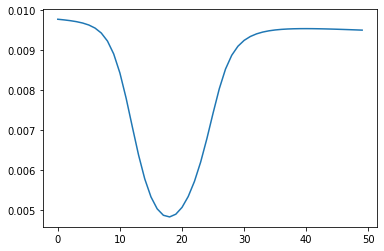

In [17]:
plt.plot(index, loss_epoch)

### Testing the Model

In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  with torch.no_grad():
        model.hidden_cell = (torch.zeros(3, 1, model.hidden_layer_size))
        seq = seq.float()
        seq= Variable(seq)
        y_pred = model(seq)
        test_outputs.append(y_pred)


We pick the index which the models gives maximum probability to. This is the class ID that we take since we anyway know that the final vector should be one-hot. We compare this with target index (the index to which we have 1 in one-hot vector) and find the accuracy of the model.

In [16]:
fin_corr = []
y = 0
for i in range(10): 
  correct = 0
  for output, label in zip(test_outputs, test_target):
    y += 1 
    label = label.reshape(-1,)
    _, target = label.max(dim=0) #changing class ID 
    _, output = output.max(dim=0) #changing to class ID
    if target == output:
      correct += 1
  fin_corr.append(correct)
print("Accuracy", (np.mean(np.array(fin_corr))/y)*100)

Accuracy 4.202961672473868


RNN seems to have some oscillation in the loss. Higher epochs will confirm this. But no such indication for LSTM model. Higher epochs will confirm this. RNN model performs slightly better owing to its epochs but if the epochs were same LSTM might have the edge. 